In [125]:
# !pip install opendatasets
# import opendatasets as od
# od.download('https://www.kaggle.com/competitions/cpe-ai-openhouse-loan-approval-prediction/overview')

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [127]:
train_df = pd.read_csv('/content/cpe-ai-openhouse-loan-approval-prediction/Loan Approval Prediction Data/train.csv')
test_df = pd.read_csv('/content/cpe-ai-openhouse-loan-approval-prediction/Loan Approval Prediction Data/test.csv')

In [128]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31640 entries, 0 to 31639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          31640 non-null  int64  
 1   person_age                  30772 non-null  float64
 2   person_income               30786 non-null  float64
 3   person_home_ownership       30766 non-null  object 
 4   person_emp_length           30804 non-null  float64
 5   loan_intent                 30792 non-null  object 
 6   loan_grade                  30776 non-null  object 
 7   loan_amnt                   30770 non-null  float64
 8   loan_int_rate               30789 non-null  float64
 9   loan_percent_income         30770 non-null  float64
 10  cb_person_default_on_file   30776 non-null  object 
 11  cb_person_cred_hist_length  30766 non-null  float64
 12  loan_status                 31640 non-null  int64  
dtypes: float64(7), int64(2), object

In [129]:
train_df = train_df.rename(columns={
    'person_age': 'age',
    'person_income' : 'income',
    'person_home_ownership' : 'home',
    'person_emp_length' : 'emp',
    'loan_intent' : 'intent',
    'loan_grade' : 'gra',
    'loan_amnt' : 'amnt',
    'loan_int_rate' : 'rate',
    'loan_percent_income' : 'income',
    'cb_person_default_on_file' : 'file',
    'cb_person_cred_hist_length' : 'cred',
    'loan_status' : 'status'
})

test_df = test_df.rename(columns={
    'person_age': 'age',
    'person_income' : 'income',
    'person_home_ownership' : 'home',
    'person_emp_length' : 'emp',
    'loan_intent' : 'intent',
    'loan_grade' : 'gra',
    'loan_amnt' : 'amnt',
    'loan_int_rate' : 'rate',
    'loan_percent_income' : 'income',
    'cb_person_default_on_file' : 'file',
    'cb_person_cred_hist_length' : 'cred',
})

In [130]:
train_df = train_df.drop(columns=['id'])
id_test = test_df.id
test_df = test_df.drop(columns=['id'])

In [131]:
train_df = pd.get_dummies(train_df, columns=['home', 'intent', 'gra', 'file'], dtype=int)
test_df = pd.get_dummies(test_df, columns=['home', 'intent', 'gra', 'file'], dtype=int)

In [132]:
train_df.describe()

,age,income,emp,amnt,rate,income,cred,status,home_MORTGAGE,home_OTHER,home_OWN,home_RENT,intent_DEBTCONSOLIDATION,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE,gra_A,gra_B,gra_C,gra_D,gra_E,gra_F,gra_G,file_N,file_Y
count,30772.000000,30786.000000,30804.000000,30770.000000,30789.000000,30770.000000,30766.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000,31640.000000
mean,27.978032,60261.018710,5.213287,9338.119825,11.768204,0.163322,5.725086,0.254172,0.258976,0.029077,0.067067,0.617257,0.139159,0.149842,0.130247,0.158565,0.158344,0.237042,0.287010,0.269121,0.201327,0.133439,0.041466,0.022661,0.017668,0.711157,0.261536
std,6.285065,31398.802001,3.450266,5690.231685,3.667865,0.100445,3.966145,0.435402,0.438079,0.168025,0.250142,0.486064,0.346118,0.356922,0.336580,0.365276,0.365069,0.425275,0.452373,0.443510,0.400998,0.340054,0.199370,0.148823,0.131742,0.453232,0.439478
min,21.000000,11664.000000,0.000046,118.000000,4.917300,0.003064,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,37753.250000,3.049404,5054.250000,8.089299,0.089005,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,52644.500000,4.964984,7673.500000,11.420053,0.133358,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,30.000000,72326.500000,6.502810,12187.750000,14.087814,0.207660,7.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,66.000000,249272.000000,25.100039,33852.000000,22.969506,0.552968,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [133]:
train_df = train_df.fillna(train_df.median())
test_df = test_df.fillna(test_df.median())

In [134]:
norm_train = MinMaxScaler().fit_transform(train_df)
train_df = pd.DataFrame(norm_train, columns=train_df.columns)

norm_test = MinMaxScaler().fit_transform(test_df)
test_df = pd.DataFrame(norm_test, columns=test_df.columns)

<Axes: >

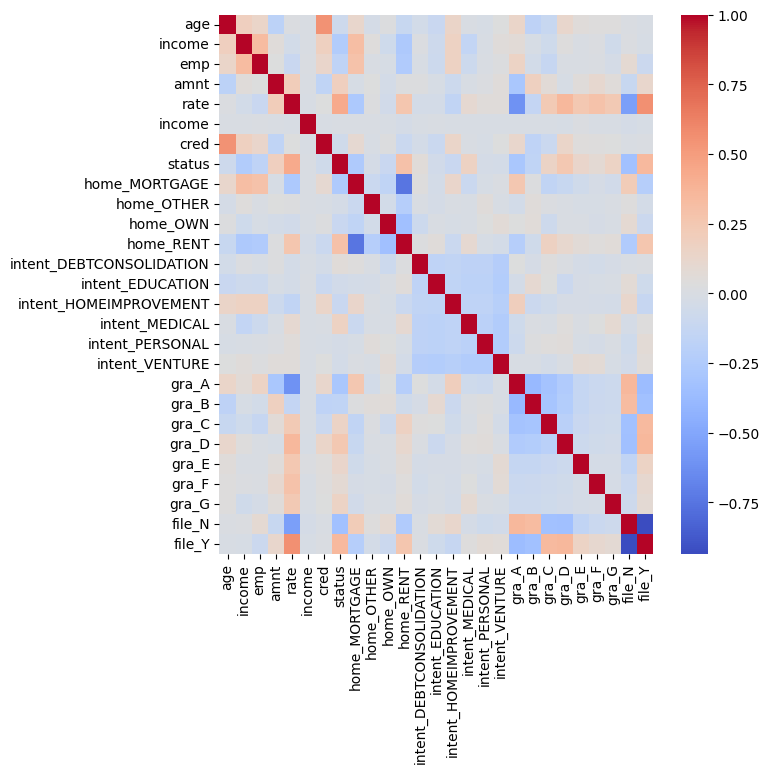

In [135]:
cor = train_df.corr()
plt.figure(figsize=(7, 7))
sns.heatmap(cor, annot=False, cmap='coolwarm')

In [136]:
y = train_df.status
x = train_df.drop(columns=['status'])

train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.2, random_state=42)

In [137]:
train_x = train_x.values.astype(np.float32)
train_y = train_y.values.astype(np.float32).reshape(-1, 1)
tensor_train_x = torch.tensor(train_x)
tensor_train_y = torch.tensor(train_y)

val_x = val_x.values.astype(np.float32)
val_y = val_y.values.astype(np.float32).reshape(-1, 1)
tensor_val_x = torch.tensor(val_x)
tensor_val_y = torch.tensor(val_y)

test_x = test_df.values.astype(np.float32)
tensor_test_x = torch.tensor(test_x)

In [138]:
class neural_network(nn.Module):
  def __init__(self, input_body):
    super(neural_network, self).__init__()
    self.layer1 = nn.Linear(input_body, 45)
    self.bn1 = nn.BatchNorm1d(45)
    self.dropout1 = nn.Dropout(0.2)

    self.layer2_1 = nn.Linear(45, 45)
    self.layer2_2 = nn.Linear(45, 128)
    self.bn2_1 = nn.BatchNorm1d(45)
    self.bn2_2 = nn.BatchNorm1d(128)
    self.dropout2 = nn.Dropout(0.2)

    self.layer3_1 = nn.Linear(128, 128)
    self.layer3_2 = nn.Linear(128, 64)
    self.bn3_1 = nn.BatchNorm1d(128)
    self.bn3_2 = nn.BatchNorm1d(64)
    self.dropout3 = nn.Dropout(0.15)

    self.layer4_1 = nn.Linear(64, 64)
    self.layer4_2 = nn.Linear(64, 16)
    self.bn4_1 = nn.BatchNorm1d(64)
    self.bn4_2 = nn.BatchNorm1d(16)
    self.ln4 = nn.LayerNorm(16)
    self.dropout4 = nn.Dropout(0.1)

    self.output = nn.Linear(16, 1)
    self.act = nn.SiLU()

  def forward(self, x):
    x = self.act(self.bn1(self.layer1(x)))
    x = self.dropout1(x)

    x = self.act(self.bn2_1(self.layer2_1(x)))
    x = self.act(self.bn2_2(self.layer2_2(x)))
    x = self.dropout2(x)

    x = self.act(self.bn3_1(self.layer3_1(x)))
    x = self.act(self.bn3_2(self.layer3_2(x)))
    x = self.dropout3(x)

    x = self.act(self.bn4_1(self.layer4_1(x)))
    x = self.act(self.ln4(self.bn4_2(self.layer4_2(x))))
    x = self.dropout4(x)

    x = self.output(x)

    return x

In [139]:
def f1_macro(y_pred, y_true, threshold=0.5):
    y_pred = y_pred.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    y_pred_class = (y_pred >= threshold).astype(int)

    f1_scores = []
    for cls in [0, 1]:
        tp = np.sum((y_true == cls) & (y_pred_class == cls))
        fp = np.sum((y_true != cls) & (y_pred_class == cls))
        fn = np.sum((y_true == cls) & (y_pred_class != cls))

        if (tp + fp == 0) or (tp + fn == 0):
            f1 = 0.0
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 0.0 if (precision + recall == 0) else 2 * (precision * recall) / (precision + recall)

        f1_scores.append(f1)

    return np.mean(f1_scores)

Epoch [1/100] | Loss(F1): 0.4258 | Loss(BCE): 1.1661
Epoch [2/100] | Loss(F1): 0.4258 | Loss(BCE): 1.1258
Epoch [3/100] | Loss(F1): 0.4258 | Loss(BCE): 1.0660
Epoch [4/100] | Loss(F1): 0.7333 | Loss(BCE): 0.9832
Epoch [5/100] | Loss(F1): 0.7203 | Loss(BCE): 0.9100
Epoch [6/100] | Loss(F1): 0.7137 | Loss(BCE): 0.8666
Epoch [7/100] | Loss(F1): 0.7128 | Loss(BCE): 0.8445
Epoch [8/100] | Loss(F1): 0.7138 | Loss(BCE): 0.8326
Epoch [9/100] | Loss(F1): 0.7148 | Loss(BCE): 0.8237
Epoch [10/100] | Loss(F1): 0.7155 | Loss(BCE): 0.8151
Epoch [11/100] | Loss(F1): 0.7203 | Loss(BCE): 0.8057
Epoch [12/100] | Loss(F1): 0.7270 | Loss(BCE): 0.7969
Epoch [13/100] | Loss(F1): 0.7349 | Loss(BCE): 0.7896
Epoch [14/100] | Loss(F1): 0.7384 | Loss(BCE): 0.7839
Epoch [15/100] | Loss(F1): 0.7416 | Loss(BCE): 0.7793
Epoch [16/100] | Loss(F1): 0.7448 | Loss(BCE): 0.7747
Epoch [17/100] | Loss(F1): 0.7469 | Loss(BCE): 0.7703
Epoch [18/100] | Loss(F1): 0.7491 | Loss(BCE): 0.7666
Epoch [19/100] | Loss(F1): 0.7495 | L

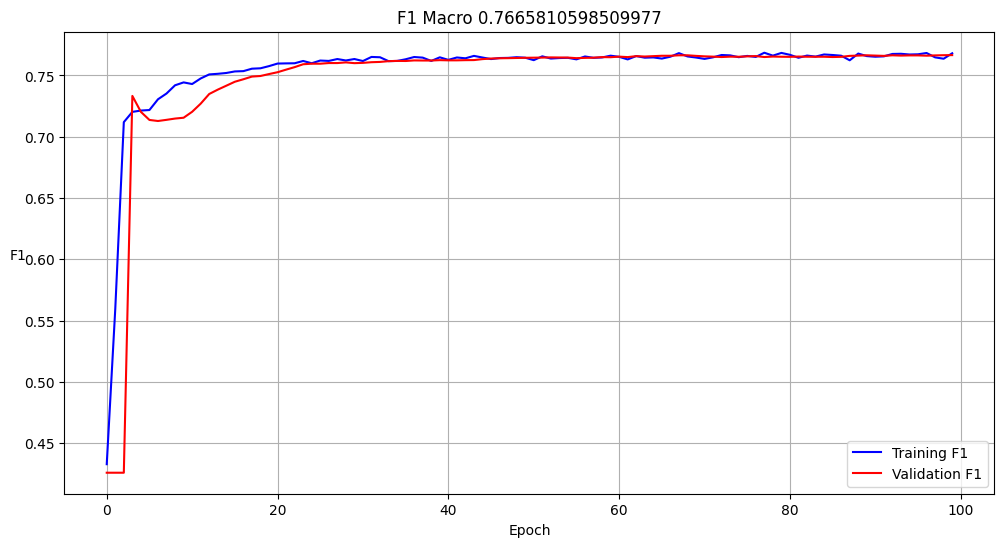

In [140]:
model = neural_network(train_x.shape[1])
pos_weight = torch.tensor([3.5])
error = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, min_lr=0.001)
# ตอนนี้ปรับบ้าๆคือ traing 40%, test 60%

col_F1, col_F1_val = [], []
epoch, n = 100, 1
for i in range(0, epoch):
  model.train()
  # Forward pass
  y_hat = model(tensor_train_x)
  loss_BCE = error(y_hat, tensor_train_y)
  loss_F1 = f1_macro(y_hat, tensor_train_y)

  # Backward + Optimize
  optimizer.zero_grad()
  loss_BCE.backward()
  optimizer.step()

  with torch.no_grad():
    y_hat = (y_hat >= 0.5).float()
    train_loss_F1 = f1_macro(y_hat, tensor_train_y)
    col_F1.append(train_loss_F1.item())

  model.eval()
  with torch.no_grad():
    y_hat_val = model(tensor_val_x)
    loss_BCE_val = error(y_hat_val, tensor_val_y)

    y_hat_val = (y_hat_val >= 0.5).float()
    loss_F1_val = f1_macro(y_hat_val, tensor_val_y)
    scheduler.step(loss_F1_val)
    col_F1_val.append(loss_F1_val.item())

  if i == (n-1):
    print(f"Epoch [{i+1}/{epoch}] | Loss(F1): {loss_F1_val:.4f} | Loss(BCE): {loss_BCE_val:.4f}")
    n += 1

torch.save(model.state_dict(), 'My_weight.pth')

plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(range(epoch), col_F1, label="Training F1", color="blue")
plt.plot(range(epoch), col_F1_val, label="Validation F1", color="red")
plt.title(f'F1 Macro {loss_F1_val}')
plt.xlabel('Epoch')
plt.ylabel('F1', rotation=0)
plt.legend()

plt.show()

In [141]:
with torch.no_grad():
  y_hat = model(tensor_test_x)
  y_hat = (y_hat >= 0.5).float()
  y_hat = y_hat.squeeze().numpy().astype(int)
y_hat = pd.DataFrame(y_hat)

summarize = pd.concat([id_test, y_hat], axis=1)
summarize.columns = ['id', 'loan_status']
summarize.to_csv('My_Answer.csv', index=False)
print(summarize['loan_status'].unique())
summarize

[0 1]


,id,loan_status
0,31641,0
1,31642,1
2,31643,0
3,31644,1
4,31645,0
...,...,...
7905,39546,0
7906,39547,1
7907,39548,0
7908,39549,1
